<a href="https://colab.research.google.com/github/olinyoder2534/TensorflowPractice/blob/main/ProductReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import gensim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [67]:
pip install python-Levenshtein

# Exploration

In [68]:
#dataset contains reviews of phone accessories
df = pd.read_json("/content/reviews_Cell_Phones_and_Accessories_5.json.gz", lines=True)
#df

In [69]:
df.head(4)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"


In [70]:
print("Max: {}".format(df['reviewText'].str.len().max()))
print("Mean: {}".format(round(df['reviewText'].str.len().mean(),3)))
print("Median: {}".format(df['reviewText'].str.len().median()))

Max: 32110
Mean: 491.84
Median: 248.0


In [71]:
df['overall'].value_counts()
#mostly positive reviews

overall
5    108664
4     39993
3     21439
1     13279
2     11064
Name: count, dtype: int64

In [72]:
print("Mean: {}".format(round(df['overall'].mean(),3)))
print("Median: {}".format(df['overall'].median()))

Mean: 4.13
Median: 5.0


In [73]:
df.shape

(194439, 9)

In [74]:
print(df.dtypes)

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object


In [75]:
df.isna().sum()
#not going to need reviewName so fine to leave NAs in

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

# Preprocessing

In [76]:
#I took a couple approaches here and have tried to clean it up a bit; however, it's still a bit messy

In [77]:
#I don't have enough RAM to run models using the entire dataset, so I'm taking a random subset of 10,000 records
subset_df = df.sample(n=10000, random_state=42)

In [78]:
subset_df['overall'].value_counts()

overall
5    5628
4    2063
3    1054
1     681
2     574
Name: count, dtype: int64

In [79]:
subset_df.shape

(10000, 9)

In [80]:
subset_df.head(4)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
156187,A1P3ACSVXZ1JUM,B00C0ZKI9Q,LO127,"[0, 0]",iBOLT xProDock Active Car Dock/Holder/Mount fo...,5,Fits perfectly,1372032000,"06 24, 2013"
102252,A2Z3IZDQUIDRR9,B008FQVO5G,yogitim,"[8, 8]",This pouch is everything that I was looking fo...,5,Great Pouch!,1361577600,"02 23, 2013"
23146,A3EOVXI1VZIHUQ,B003Y74AZ2,"Z. Freeman ""Zach""","[1, 2]",First of all - the case I had on my iPhone 4 p...,3,An average iPhone case - nothing fancy,1296604800,"02 2, 2011"
86461,AWU526GBZ64MH,B007ZL0TJ4,Bree,"[0, 0]",I ordered this case because I had the same cas...,5,Great Case,1379635200,"09 20, 2013"


In [81]:
review_text = subset_df.reviewText.apply(gensim.utils.simple_preprocess)
review_text

156187    [ibolt, xprodock, active, car, dock, holder, m...
102252    [this, pouch, is, everything, that, was, looki...
23146     [first, of, all, the, case, had, on, my, iphon...
86461     [ordered, this, case, because, had, the, same,...
62407     [bought, few, of, these, as, gifts, they, were...
                                ...                        
121486    [bought, this, specific, adapter, because, the...
307       [ve, been, buying, these, headsets, for, sever...
80726     [the, tylt, powerplant, is, essentially, recha...
40551     [paid, less, than, for, this, product, for, my...
66990     [was, hesitant, buying, this, as, have, never,...
Name: reviewText, Length: 10000, dtype: object

In [82]:
#review_text.reset_index(drop=True, inplace=True)
#review_text.loc[0]

In [83]:
#review_text

In [84]:
#resampling using undersampling, using full dataset here (this is a seperate approach to the subset_df)
class_counts = df['overall'].value_counts()
min_class_count = class_counts.min()

undersampled_df = pd.concat([df[df['overall'] == cls].sample(min_class_count, replace=False) for cls in class_counts.index])

undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [85]:
#creating a new dataset with balanced classes
df1 = undersampled_df.drop(labels = ["reviewerID", "asin", "reviewerName", "helpful", "summary", "unixReviewTime", "reviewTime"], axis = 1)

In [86]:
df1['ReviewText2'] = df1['reviewText'].apply(lambda x: gensim.utils.simple_preprocess(x))
df1.head()

,reviewText,overall,ReviewText2
0,Although it fits well on my HTC EVO But i coul...,1,"[although, it, fits, well, on, my, htc, evo, b..."
1,"Fits the screen precisely, all holes line up. ...",5,"[fits, the, screen, precisely, all, holes, lin..."
2,"What can I say? It's tape...I may be biased, b...",2,"[what, can, say, it, tape, may, be, biased, bu..."
3,"Alrite, ok,, fair, slim fit good 4 iphone , ca...",2,"[alrite, ok, fair, slim, fit, good, iphone, ca..."
4,I had never heard of SmackTom and was a little...,5,"[had, never, heard, of, smacktom, and, was, li..."


In [87]:
df1['overall'].value_counts()

overall
1    11064
5    11064
2    11064
4    11064
3    11064
Name: count, dtype: int64

In [88]:
df1['ReviewText2'].dtypes

dtype('O')

In [89]:
df1['ReviewText2'].str.len().max()

3206

In [90]:
df1['ReviewText2'].str.len().mean()

88.2136478669559

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df1['ReviewText2'],
                                                    df1['overall'], test_size=0.3)

In [92]:
X_train

15817    [would, definitely, recommend, this, it, very,...
44235    [wasn, sure, how, it, indicates, charging, it,...
16235    [works, good, and, the, back, cover, fits, pre...
41380    [this, case, fit, and, looks, really, nice, wi...
9142     [worked, to, an, extent, this, charger, is, ac...
                               ...                        
18013    [if, you, hearing, what, with, every, call, by...
5465     [ordered, these, for, my, husbands, phone, so,...
28104    [waitied, forever, for, this, to, get, here, a...
9967     [snaps, on, easy, and, still, have, access, to...
29703    [so, the, old, adage, of, you, get, what, you,...
Name: ReviewText2, Length: 38724, dtype: object

## Word2Vec # 1
Using balanced data




In [93]:
w2v_model = gensim.models.Word2Vec(X_train,
                                   #vector_size=100,
                                   window=5,
                                   min_count=2)

In [94]:
w2v_model.wv.most_similar('bad')

[('good', 0.66915363073349),
 ('terrible', 0.6460320949554443),
 ('awful', 0.5988014340400696),
 ('horrible', 0.5611162185668945),
 ('amazing', 0.5394986867904663),
 ('poor', 0.539130449295044),
 ('ridiculous', 0.5383977890014648),
 ('obvious', 0.5177709460258484),
 ('okay', 0.5151788592338562),
 ('cheap', 0.5121865272521973)]

In [95]:
words = set(w2v_model.wv.index_to_key)

In [96]:
#words

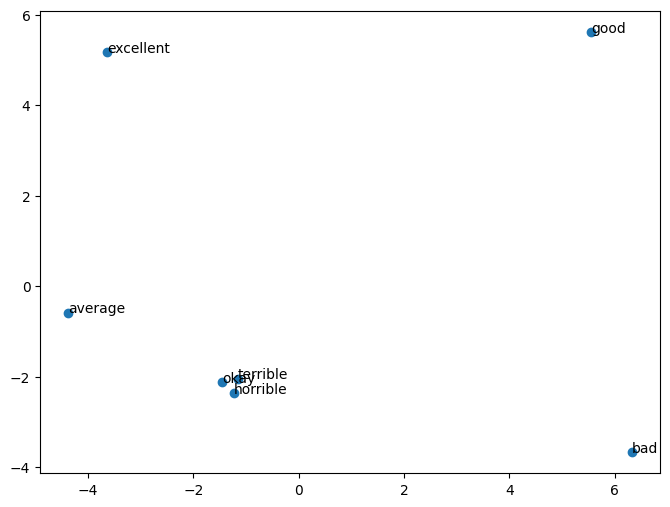

In [97]:
#pca plot for words to see how well word2vec model did
words = ['good', 'bad', 'horrible', 'excellent', 'terrible', 'average', 'okay']

word_vectors = np.array([w2v_model.wv[word] for word in words])

#pca
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(word_vectors)

#2 pcs
plt.figure(figsize=(8, 6))
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], marker='o')
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_vectors[i, 0], pca_vectors[i, 1]))
plt.show()

In [98]:
df1.head()

,reviewText,overall,ReviewText2
0,Although it fits well on my HTC EVO But i coul...,1,"[although, it, fits, well, on, my, htc, evo, b..."
1,"Fits the screen precisely, all holes line up. ...",5,"[fits, the, screen, precisely, all, holes, lin..."
2,"What can I say? It's tape...I may be biased, b...",2,"[what, can, say, it, tape, may, be, biased, bu..."
3,"Alrite, ok,, fair, slim fit good 4 iphone , ca...",2,"[alrite, ok, fair, slim, fit, good, iphone, ca..."
4,I had never heard of SmackTom and was a little...,5,"[had, never, heard, of, smacktom, and, was, li..."


In [99]:
#from keras.preprocessing.text import Tokenizer

#tokenizer = Tokenizer()

#Convert the words to integers
#X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

#max_length = max(len(review) for review in X_train)

#pad or truncate to the same length
#X_train_padded = pad_sequences(X_train, maxlen=max_length, value=0)
#X_test_padded = pad_sequences(X_test, maxlen=max_length, value=0)

In [100]:
X_train

15817    [would, definitely, recommend, this, it, very,...
44235    [wasn, sure, how, it, indicates, charging, it,...
16235    [works, good, and, the, back, cover, fits, pre...
41380    [this, case, fit, and, looks, really, nice, wi...
9142     [worked, to, an, extent, this, charger, is, ac...
                               ...                        
18013    [if, you, hearing, what, with, every, call, by...
5465     [ordered, these, for, my, husbands, phone, so,...
28104    [waitied, forever, for, this, to, get, here, a...
9967     [snaps, on, easy, and, still, have, access, to...
29703    [so, the, old, adage, of, you, get, what, you,...
Name: ReviewText2, Length: 38724, dtype: object

In [101]:
X_train_vecs = []
X_test_vecs = []

#convert each sentence in X_train to a vector
for sentence in X_train:
    vec = np.zeros(w2v_model.vector_size)
    for word in sentence:
        if word in words:
            vec += w2v_model.wv[word]
    vec /= len(sentence)
    X_train_vecs.append(vec)

#convert each sentence in X_test to a vector
for sentence in X_test:
    vec = np.zeros(w2v_model.vector_size)
    for word in sentence:
        if word in words:
            vec += w2v_model.wv[word]
    vec /= len(sentence)
    X_test_vecs.append(vec)

#convert lists to numpy arrays
X_train_vecs = np.array(X_train_vecs)
X_test_vecs = np.array(X_test_vecs)

<ipython-input-101-9d9ee9271aed>:10: RuntimeWarning: invalid value encountered in divide
  vec /= len(sentence)
<ipython-input-101-9d9ee9271aed>:19: RuntimeWarning: invalid value encountered in divide
  vec /= len(sentence)


In [102]:
X_train_vecs

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00441243,  0.00386195, -0.00012239, ..., -0.00078544,
        -0.00490997, -0.0076931 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [163]:
X_train_vecs.shape
y_train.shape

(38724,)

In [164]:
#average vectors
X_train_vect_avg = []
for v in X_train_vecs:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vecs:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [168]:
len(X_train_vect_avg)

38724

In [104]:
#for i in len(X_train_vect_avg):
  #if i == 0:
    #drop i from X_train_vect_avg & do the same for test, & remove corresponding index from train or test

## Word2Vec #2
Using subset_df

In [105]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [106]:
model.build_vocab(review_text, progress_per=1000)

In [107]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(3194396, 4400430)

In [108]:
word = "good"
model.wv[word]

array([ 0.84478307,  0.03595582, -1.1847414 , -0.34496337, -0.03425371,
       -0.20568359, -0.7215651 , -0.6049443 ,  1.2582487 ,  0.3105398 ,
       -0.71349776,  0.52236694, -0.47027484,  1.836606  ,  0.1713065 ,
        0.3314552 , -1.8516357 ,  0.4994768 ,  1.3239365 ,  0.6368516 ,
       -0.23592043, -1.3005517 , -0.3810848 , -1.2239963 ,  1.179227  ,
        0.30377862,  0.5345077 ,  1.691695  , -1.3037235 , -0.26974306,
        1.6318213 , -1.2603905 ,  1.8961829 ,  0.40732497, -1.2242619 ,
       -0.8924616 ,  1.2833836 ,  0.77559423, -1.1734535 ,  2.3747752 ,
        0.5058221 ,  0.9514771 ,  0.94707364, -1.3335865 , -0.05505715,
       -0.7143027 , -0.09229028, -0.3836412 ,  0.67082345, -0.62780017,
        1.5750273 , -0.5290603 ,  0.03237111,  0.75947297,  0.48538905,
        1.2478751 , -0.43379575, -0.13442962, -1.1543772 , -1.2178602 ,
        1.0433681 , -0.8512416 , -0.00931606,  0.09225611, -0.29893   ,
        0.3604319 ,  0.5008331 , -0.26613274, -1.3879855 ,  0.26

In [109]:
model.wv.most_similar("good")

[('decent', 0.7842137217521667),
 ('great', 0.7329957485198975),
 ('fantastic', 0.6758183240890503),
 ('reasonable', 0.6686556935310364),
 ('pricy', 0.6435008645057678),
 ('ok', 0.6420198082923889),
 ('excellent', 0.634128212928772),
 ('booming', 0.6123116612434387),
 ('awesome', 0.6118017435073853),
 ('amazing', 0.6111575961112976)]

In [110]:
model.wv.most_similar("bad")

[('guess', 0.7427626848220825),
 ('okay', 0.7356058955192566),
 ('ok', 0.7115803956985474),
 ('fault', 0.6653526425361633),
 ('rave', 0.6651091575622559),
 ('complaining', 0.661050021648407),
 ('faults', 0.660409152507782),
 ('honestly', 0.6566110849380493),
 ('huge', 0.6520747542381287),
 ('why', 0.6486830115318298)]

In [111]:
model.wv.most_similar("okay")

[('ok', 0.8874257206916809),
 ('alright', 0.8051456212997437),
 ('suprised', 0.7929761409759521),
 ('pleasing', 0.7868425846099854),
 ('expecting', 0.7768610119819641),
 ('pricey', 0.7758657932281494),
 ('lacking', 0.7741968035697937),
 ('picky', 0.7731367349624634),
 ('yes', 0.766976535320282),
 ('steep', 0.7615055441856384)]

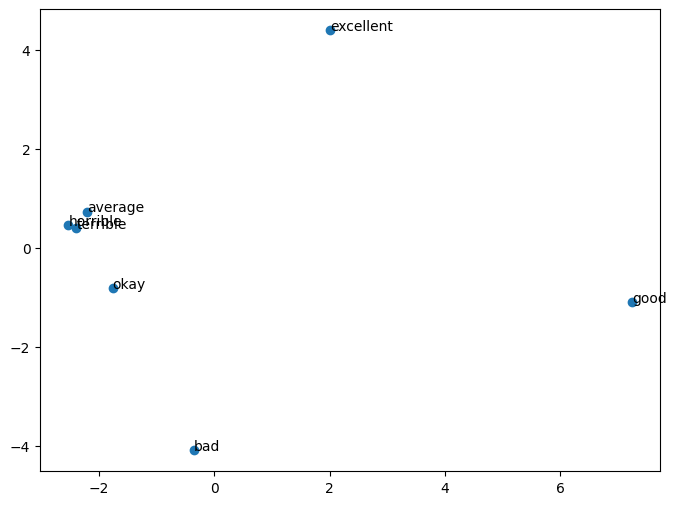

In [112]:
#pca plot for words to see how well word2vec model did
words = ['good', 'bad', 'horrible', 'excellent', 'terrible', 'average', 'okay']

word_vectors = np.array([model.wv[word] for word in words])

#pca
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(word_vectors)

#2 pcs
plt.figure(figsize=(8, 6))
plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], marker='o')
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_vectors[i, 0], pca_vectors[i, 1]))
plt.show()

# Sentiment Analysis

## Further Preprocesing

In [113]:
#convert text to vector based on word embeddings
def text_to_vector(text):
    words = text.split()
    vector = np.zeros((model.vector_size,))
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
    return vector

In [114]:
#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
#modeltoken = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#convert text to vector using the pre-trained model
#def text_to_vector_transformers(text):
    #inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    #outputs = modeltoken(**inputs)
    #logits = outputs.logits
    #probabilities = torch.nn.functional.softmax(logits, dim=1)
    #vector = probabilities.detach().numpy()[0]
    #return vector

In [115]:
#subset_df
X = np.array([text_to_vector(text) for text in subset_df['reviewText']])
y = subset_df['overall']

In [116]:
#Not enough ram to run the following

#from torch.nn.functional import softmax

#trying to use batches instead of converting individually
#def batch_text_to_vector_transformers(texts):
    #inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    #outputs = modeltoken(**inputs)
    #logits = outputs.logits
    #probabilities = softmax(logits, dim=1)
    #vectors = probabilities.detach().numpy()
    #return vectors

#batching
#batch_size = 32
#num_texts = len(subset_df['reviewText'])
#num_batches = (num_texts + batch_size - 1) // batch_size

#X = []

#for i in range(num_batches):
    #start_idx = i * batch_size
    #end_idx = min((i + 1) * batch_size, num_texts)
    #batch_texts = subset_df['reviewText'][start_idx:end_idx].tolist()
    #batch_vectors = batch_text_to_vector_transformers(batch_texts)
    #X.extend(batch_vectors)

#X = np.array(X)
#y = subset_df['overall']

In [117]:
#rebalance data
#smote = SMOTE(random_state=42)

In [118]:
#resampling using undersampling, using full dataset here
#class_counts = df['overall'].value_counts()
#min_class_count = class_counts.min()

#undersampled_df = pd.concat([df[df['overall'] == cls].sample(min_class_count, replace=False) for cls in class_counts.index])

#undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [119]:
#undersampled_df['overall'].value_counts()

In [120]:
#X2 = np.array([text_to_vector(text) for text in undersampled_df['reviewText']])
#y2 = undersampled_df['overall']

In [121]:
#X_resampled, y_resampled = smote.fit_resample(X, y)

In [122]:
#print(Counter(y))
#print(Counter(y_resampled))

In [123]:
#X_resampled[0]

In [124]:
#y_resampled

In [125]:
#y_resampled.reset_index(drop=True, inplace=True)

In [126]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

## Naive Bayes

### Balanced Data

In [127]:
X_train_vect_avg[:10]
#len(X_train_vect_avg)

[0.0,
 0.0,
 -0.0013011311657886802,
 0.0,
 0.0,
 -0.007173341558756011,
 0.0,
 0.0,
 0.0,
 -0.002551648147208126]

In [169]:
X_train_vect_avg_array = np.array(X_train_vect_avg)
X_test_vect_avg_array = np.array(X_test_vect_avg)

In [170]:
X_train_vect_avg_array.shape

(38724,)

In [176]:
X_train_vect_avg_array = np.array(X_train_vect_avg_array).reshape(-1, 1)
X_test_vect_avg_array = np.array(X_test_vect_avg_array).reshape(-1, 1)

In [178]:
y_train

0        5
1        1
2        2
3        4
4        2
        ..
38719    1
38720    5
38721    2
38722    4
38723    3
Name: overall, Length: 38724, dtype: int64

In [174]:
X_train_vect_avg_array.shape

(38724, 1)

In [173]:
print(sum(np.isnan(X_train_vect_avg_array)))
print(sum(np.isnan(y_train)))

[18]
0


In [183]:
print(np.array(y_train))

[5 1 2 ... 2 4 3]


In [189]:
y_train = y_train.values

dataset = pd.DataFrame(X_train_vect_avg_array, columns=['vec']).assign(label=y_train)

In [190]:
print(dataset[:10])

        vec  label
0  0.000000      5
1  0.000000      1
2 -0.001301      2
3  0.000000      4
4  0.000000      2
5 -0.007173      5
6  0.000000      5
7  0.000000      5
8  0.000000      3
9 -0.002552      5


In [191]:
dataset['vec'] = dataset['vec'].fillna(0)

In [192]:
dataset.dropna(subset=['vec'], inplace=True)
dataset.drop(dataset[dataset['vec'] == 0].index, inplace=True)

In [200]:
print(dataset[:5])

         vec  label
2  -0.001301      2
5  -0.007173      5
9  -0.002552      5
10 -0.002442      4
14 -0.002869      5


In [198]:
#so I'm gonna do another train-test split from 'dataset' here even though it's already supposedly the training data

Xnew = dataset['vec']
ynew = dataset['label']

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xnew, ynew, test_size=0.3, random_state=42)

In [201]:
Xnew

2       -0.001301
5       -0.007173
9       -0.002552
10      -0.002442
14      -0.002869
           ...   
38699   -0.004038
38705   -0.001291
38708   -0.001290
38713   -0.005048
38716   -0.003584
Name: vec, Length: 11549, dtype: float64

In [96]:
#tolerance of 1
correct_predictions = 0

for pred, true in zip(y_predNB, y_test):
    if abs(pred - true) <= 1:
        correct_predictions += 1

accuracyNB2 = correct_predictions / len(y_test)
accuracyNB2

0.3973246565437455

In [108]:
y_predNB[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [97]:
#make vectors only contain values that are non-negative
def preprocess_embeddings(embeddings):
    min_embedding = np.min(embeddings)
    if min_embedding < 0:
        embeddings -= min_embedding
    return embeddings

In [100]:
#make vectors only contain values that are non-negative
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

In [103]:
naive_bayes1 = MultinomialNB()
naive_bayes1.fit(X_train_scaled, y_train1)

MultinomialNB()

In [104]:
y_predNB1 = naive_bayes.predict(X_test_scaled)

accuracyNB3 = accuracy_score(y_test1, y_predNB1)
accuracyNB3
#much better accuracy overall, but likely bc we're just predicting high values

0.561

In [107]:
y_predNB1[:100]
#just predcting 5?!?!

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [106]:
y_test[:10]

25582    1
55141    1
48012    5
42066    2
10169    1
48431    5
22917    1
44334    2
54377    4
10882    4
Name: overall, dtype: int64

In [109]:
df['reviewText'][162073]

'I have purchase a few smartphone dash mount and are still looking for the right one. This one have a great concept using a claw grip but every time I put the phone on it will just sag down, even though i have tightening it enough. I just kept moving the phone up it will just come back down. If they make the bearing better it will be the best dash mount ever.I have read all of the reviews and are not sure if the one I got is broken and does not hold well but i do not think it will last long.'

In [110]:
df['overall'][162073]

1

In [112]:
#tolerance of 1 (e.g. a prediction of 4 when the real value was 5 will be marked correct)
correct_predictions = 0

for pred, true in zip(y_predNB, y_test):
    if abs(pred - true) <= 1:
        correct_predictions += 1

accuracyNB4 = correct_predictions / len(y_test)
accuracyNB4

0.3973246565437455

In [114]:
review1 = 'Bad, do not buy this product. It is not worth it. I will never allow anyone I know to purchase this product. Horrible, terrible, awful.'
#'This product is amazing. I would highly recommend it to everyone!!'
#'This product is okay. It does the job fine I guess.'
#'Bad, do not buy this product. It is not worth it. I will never allow anyone I know to purchase this product. Horrible, terrible, awful.'

#review1= text_to_vector(review1)
#review1 = review1.reshape(1, -1)

In [115]:
review1_vector = text_to_vector(review1)
review1_vector = review1_vector.reshape(1, -1)

In [116]:
naive_bayes.predict(review1_vector)

array([4])

## Random Forest

In [203]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier()

#grid search hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   8.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=  11.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=  11.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   7.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   8.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=  11.5s
[CV] END max_depth=None, m

In [ ]:
best_rf_classifier = grid_search.best_estimator_
y_predRF = best_rf_classifier.predict(X_test)

In [ ]:
accuracyRF = accuracy_score(y_test, y_predRF)
accuracyRF

0.5483333333333333

In [ ]:
#tolerance of 1 (e.g. a prediction of 4 when the real value was 5 will be marked correct)
correct_predictionsRF = 0

for pred, true in zip(y_predRF, y_test):
    if abs(pred - true) <= 1:
        correct_predictionsRF += 1

accuracyRF2 = correct_predictionsRF / len(y_test)
accuracyRF2
#RF is often 1 off from the true value (if it were high-medium-low instead of 1-5, rf would do quite well)

0.7813333333333333

In [ ]:
best_rf_classifier.predict(review1)

array([5])

## RNN using LSTM

In [ ]:
max_length = subset_df['reviewText'].str.len().max()
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [ ]:
X_train.dtype

dtype('int32')

In [ ]:
subset_df['reviewText'].dtypes

dtype('O')

In [ ]:
vocab_size = len(model.wv.index_to_key)
embedding_dim = model.vector_size
num_classes = len(subset_df['overall'].unique())

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
modelLSTM.add(LSTM(units=100))
modelLSTM.add(Dense(units=num_classes, activation='softmax'))

In [ ]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

In [ ]:
modelLSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelLSTM.fit(X_train, y_train_adjusted, epochs=5, batch_size=32, validation_data=(X_test, y_test_adjusted))

Epoch 1/5
 11/219 [>.............................] - ETA: 7:37:04 - loss: 1.5533 - accuracy: 0.5114

In [ ]:
modelLSTM.evaluate(X_test,y_test)

In [ ]:
predictionsLSTM = modelLSTM.predict(X_test) + 1
np.argmax(predictionsLSTM[1])

In [ ]:
y_test[1]

# Auto Complete

In [ ]:
#convert text into numerical sequences
def text_to_sequence(text, model):
    words = text.split()
    sequence = [model.key_to_index[word] for word in words if word in model.key_to_index]
    return sequence

In [ ]:
max_sequence_length = subset_df['reviewText'].str.len().max()

X_sequences = [text_to_sequence(text, model.wv) for text in subset_df['reviewText']]
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

X_sequences = np.array(X_padded)
X_sequences

array([[   7,  113,    8, ...,    0,    0,    0],
       [ 921,    4,  334, ...,    0,    0,    0],
       [   6,   36,    0, ...,    0,    0,    0],
       ...,
       [   4, 2241, 2408, ...,    0,    0,    0],
       [ 694,  258,   56, ...,    0,    0,    0],
       [  19, 2519,  489, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_sequences.shape

(10000, 25435)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_sequences, y, test_size=0.3, random_state=42)

In [ ]:
vocab_size = len(model.wv.index_to_key)
embedding_dim = model.vector_size
#num_classes = len(subset_df['overall'].unique())

In [ ]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_rnn.add(LSTM(units=100, return_sequences=True))
model_rnn.add(LSTM(units=100))
model_rnn.add(Dense(vocab_size, activation='softmax'))

In [ ]:
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model_rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25435, 100)        994000    
                                                                 
 lstm (LSTM)                 (None, 25435, 100)        80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9940)              1003940   
                                                                 
Total params: 2158740 (8.23 MB)
Trainable params: 2158740 (8.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
#not enough RAM :(, could use a HMM instead
#history = model_rnn.fit(X_train1, y_train1, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/10
